
# Monitor data processing



## Load  libraries

In [103]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# manipulation libraries
import pandas as pd
import datetime
from siuba import *

# visualization
import plotnine as p9
p9.theme_set(p9.theme_linedraw()) # default theme

# aws connection
import boto3
import awswrangler as wr

# local libraries
from src import utils

In [104]:
conn = utils.connect_athena(path='../configs/athena.yaml')

## Private observed


### daily

In [105]:
#df_daily = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/public/daily/write_index/daily.csv", sep = ",")


In [106]:
qry = """select last_updated_utc, region_slug, region_name, country_name, 
        country_iso_code, country_idb_code, region_type, population, 
        timezone, year, month, day, dow, 
        observed, expected_2020,
        ratio_20, tcp, dashboard,
        date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
    from spd_sdv_santiagoi_norelevancedata.daily_index"""
df_daily = pd.read_sql_query(qry, conn)

In [107]:
print(df_daily.shape)
# (52264, 18)
# (66490, 18)
# (67826, 18)
# (68688, 18)
# (70200, 19)
# (72360, 19)
df_daily.head()

(77404, 19)


,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,date
0,2022-02-28 15:25:13.975,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2021,12,4,6,123039206,142782007.0,0.861728,-13.827233,TRUE,2021-12-04
1,2022-02-28 15:25:13.975,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2021,11,20,6,139541357,142782007.0,0.977304,-2.269649,TRUE,2021-11-20
2,2022-02-28 15:25:13.975,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2020,5,23,6,32400025,142782007.0,0.226920,-77.308048,TRUE,2020-05-23
3,2022-02-28 15:25:13.975,country_dominican_republic,República Dominicana,Dominican Republic,DO,DR,country,10847904,America/Santo_Domingo,2021,10,18,1,98681391,70735238.0,1.395081,39.508106,TRUE,2021-10-18
4,2022-02-28 15:25:13.975,country_dominican_republic,República Dominicana,Dominican Republic,DO,DR,country,10847904,America/Santo_Domingo,2021,11,1,1,85832631,70735238.0,1.213435,21.343525,TRUE,2021-11-01


In [108]:
(df_daily[(df_daily.date >= '2021-11-01') & (df_daily.date < '2022-11-30')]
 >> group_by('date')
 >> summarize(regions = _.region_slug.nunique())
 >> arrange('date')
 >> group_by('regions')
 >> summarize(n = _.date.nunique())
)

,regions,n
0,78,12
1,108,107


In [109]:
(df_daily 
 >> filter(_.dashboard == 'TRUE')
 >> group_by('region_slug')
 >> summarize(n_count = _.last_updated_utc.count())
 >> arrange('n_count')
 >> group_by('n_count')
 >> summarize(n = _.region_slug.count())
)


,n_count,n
0,720,74
1,721,4


In [110]:
#(df_daily 
# >> filter(_.dashboard == 'TRUE')
# >> group_by('region_slug')
# >> summarize(n_count = _.last_updated_utc.count(),
#             min_date = _.date.min(), 
#             max_date = _.date.max())
# >> arrange('n_count')
#)

In [111]:
(df_daily 
 >> group_by('dashboard')
 >> summarize(n_count = _.region_slug.nunique())
) # 30 - 78

,dashboard,n_count
0,FALSE,30
1,TRUE,78


In [112]:
if False:
    print(df_daily
     >> filter(_.tcp > 200, _.dashboard == 'TRUE')
     >> group_by('dashboard', 'region_slug')
     >> summarize(n_count = _.region_slug.nunique())
    )

/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


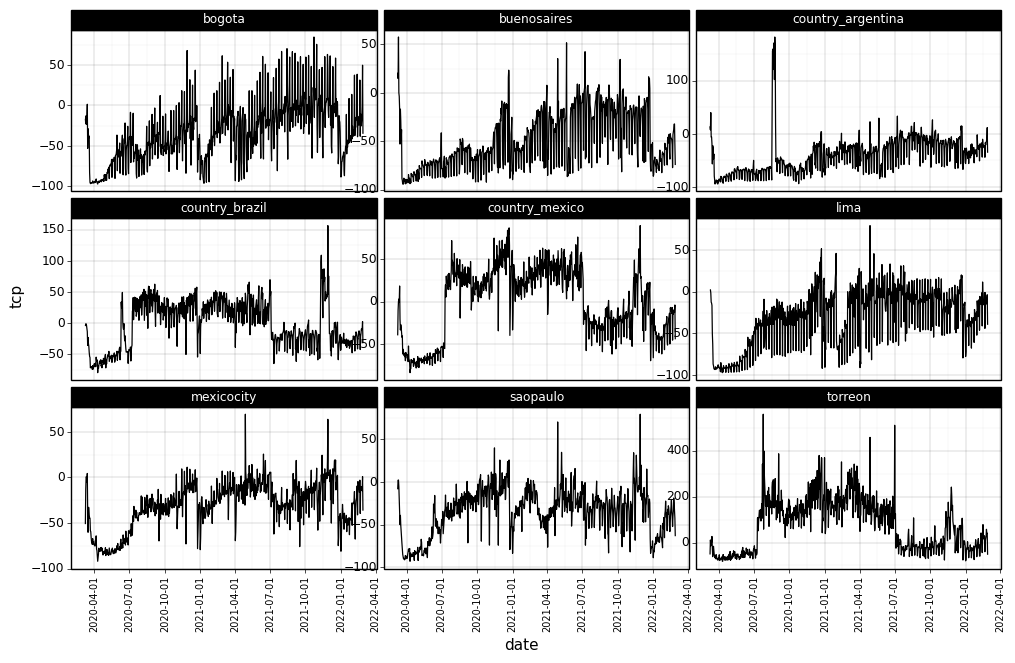

<ggplot: (8729322179369)>


In [113]:
if True: 
    #df_pl = df_daily.loc[(df_daily.region_slug.isin(['lima'])) & (df_daily.month == 7) & (df_daily.year == 2021)]
    df_pl = df_daily.loc[(df_daily.region_slug.isin(['country_mexico', 'country_brazil', 
                                                     'mexicocity', 'lima', 'torreon',
                                                    'saopaulo', 'buenosaires', 'country_argentina', 
                                                    'bogota']))]
    print(p9.ggplot(df_pl, p9.aes(x = 'date', y='tcp', group = 'region_slug')) 
     + p9.geom_line() 
     + p9.facet_wrap('region_slug', scales='free_y')
     #+ p9.geom_point()
     + p9.theme(figure_size=(12, 7),
                axis_text_x=p9.element_text(size = 7, angle = 90)) )

In [114]:
df_daily.date.max()

Timestamp('2022-02-27 00:00:00')

In [115]:
if True:
    # Remove countries columns
    df_daily.loc[df_daily.region_slug.isin(['country_brazil', 'country_mexico']), 'tcp'] = None
    df_daily.loc[df_daily.region_slug.isin(['country_brazil', 'country_mexico']), 'dashboard'] = 'FALSE'
    # Remove date column
    df_daily = df_daily.drop(columns=['date'])
df_daily.head(3)    

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-02-28 15:25:13.975,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2021,12,4,6,123039206,142782007.0,0.861728,-13.827233,TRUE
1,2022-02-28 15:25:13.975,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2021,11,20,6,139541357,142782007.0,0.977304,-2.269649,TRUE
2,2022-02-28 15:25:13.975,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2020,5,23,6,32400025,142782007.0,0.226920,-77.308048,TRUE


In [116]:
# Write
if True:
    df_daily.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/daily_pr.csv", index=False)

### weekly

In [117]:
qry = """select *
from spd_sdv_santiagoi_norelevancedata.weekly_index """
df = pd.read_sql_query(qry, conn)

In [118]:
df.loc[df.region_slug.isin(['country_brazil', 'country_mexico']), 'dashboard'] = 'FALSE'

In [119]:
qry = """select last_updated_utc, region_slug, region_name, country_name, 
	country_iso_code, country_idb_code, region_type, population, 
	timezone,  week_number, week_number_obs, 
    min_year, min_month, min_day, max_month, max_day, 
    observed, expected_2020,
	ratio_20, tcp, dashboard,
    date_parse(concat(cast(min_year as varchar), ' ', cast(min_month as varchar), ' ', cast(min_day as varchar)), '%Y %m %e') date
from spd_sdv_santiagoi_norelevancedata.weekly_index """
df_weekly = pd.read_sql_query(qry, conn)

In [120]:
print(df_weekly.shape)
# (8085, 21)
# (10516, 21)
# (10633, 21)
# (10867, 21)
# (11218, 21)
#df_weekly.head()

(12088, 22)


In [121]:
df_weekly.date.max()

Timestamp('2022-02-21 00:00:00')

In [122]:
regions_daily = df_daily[df_daily.dashboard == 'TRUE'].region_slug.unique().tolist()
df_weekly.loc[df_weekly.region_slug.isin(regions_daily) == False, 'dashboard'] = 'FALSE'
print(df_weekly.shape)

(12088, 22)


In [123]:
(df_weekly 
 >> filter(_.dashboard == 'TRUE')
 >> group_by('region_slug')
 >> summarize(n_count = _.last_updated_utc.count())
 >> arrange('n_count')
 >> group_by('n_count')
 >> summarize(n = _.region_slug.count())
)

,n_count,n
0,104,76


In [124]:
(df_weekly 
 >> group_by('dashboard')
 >> summarize(n_count = _.region_slug.nunique())
)

,dashboard,n_count
0,FALSE,41
1,TRUE,76


In [125]:
if True:
    print(df_weekly
     >> filter(_.tcp > 200, _.dashboard == 'TRUE')
     >> group_by('dashboard', 'region_slug')
     >> summarize(n_count = _.region_slug.nunique())
    )

  dashboard region_slug  n_count
0      TRUE     torreon        1


/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


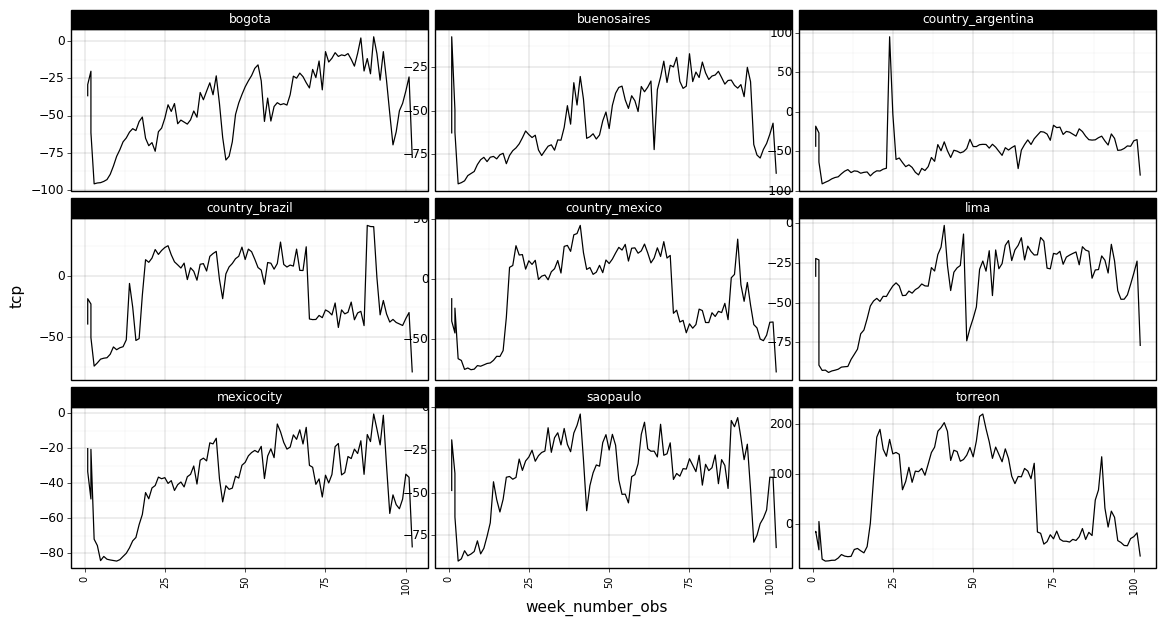

<ggplot: (8729322827037)>


In [126]:
if True: 
    df_pl = df_weekly.loc[df_weekly.region_slug.isin(['country_mexico', 'country_brazil', 
                                                     'mexicocity', 'lima', 'torreon',
                                                    'saopaulo', 'buenosaires', 'country_argentina', 
                                                    'bogota'])]
    print(p9.ggplot(df_pl, p9.aes(x = 'week_number_obs', y='tcp', group = 'region_slug')) 
     + p9.geom_line() 
     + p9.facet_wrap('region_slug', scales='free_y')          
     + p9.theme(figure_size=(14, 7),
                axis_text_x=p9.element_text(size = 7, angle = 90)) )

In [127]:
if True:
    # Remove countries columns
    df_weekly.loc[df_weekly.region_slug.isin(['country_brazil', 'country_mexico']), 'tcp'] = None
    df_weekly.loc[df_weekly.region_slug.isin(['country_brazil', 'country_mexico']), 'dashboard'] = 'FALSE'
    # Remove date column
    df_weekly = df_weekly.drop(columns=['date'])
df_weekly.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,week_number,...,min_year,min_month,min_day,max_month,max_day,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-02-28 16:22:16.980,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,27,...,2021,7,5,7,11,216075942,315011892,0.685929,-31.407052,TRUE
1,2022-02-28 16:22:16.980,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,1,...,2021,1,4,1,10,169999553,315011892,0.539661,-46.033925,TRUE
2,2022-02-28 16:22:16.980,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,34,...,2021,8,23,8,29,203331247,315011892,0.645472,-35.452835,TRUE


In [128]:
# Write
if True:
    df_weekly.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/weekly_pr.csv", index=False)
    

## Public observed

### daily

In [129]:
#df_daily = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/daily_pr.csv")
df_daily.head()

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-02-28 15:25:13.975,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2021,12,4,6,123039206,142782007.0,0.861728,-13.827233,TRUE
1,2022-02-28 15:25:13.975,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2021,11,20,6,139541357,142782007.0,0.977304,-2.269649,TRUE
2,2022-02-28 15:25:13.975,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2020,5,23,6,32400025,142782007.0,0.226920,-77.308048,TRUE
3,2022-02-28 15:25:13.975,country_dominican_republic,República Dominicana,Dominican Republic,DO,DR,country,10847904,America/Santo_Domingo,2021,10,18,1,98681391,70735238.0,1.395081,39.508106,TRUE
4,2022-02-28 15:25:13.975,country_dominican_republic,República Dominicana,Dominican Republic,DO,DR,country,10847904,America/Santo_Domingo,2021,11,1,1,85832631,70735238.0,1.213435,21.343525,TRUE


In [130]:
df_daily = df_daily[df_daily.dashboard.isin([True, 'TRUE'])].drop(['observed', 'expected_2020', 'dashboard', 'ratio_20'], axis=1)
df_daily.shape

(54722, 14)

In [131]:
if True:
    df_daily.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/public/daily/write_index/daily_pu.csv", index=False)

### weekly

In [132]:
#df_weekly = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/weekly_pr.csv")
df_weekly.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,week_number,...,min_year,min_month,min_day,max_month,max_day,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-02-28 16:22:16.980,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,27,...,2021,7,5,7,11,216075942,315011892,0.685929,-31.407052,TRUE
1,2022-02-28 16:22:16.980,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,1,...,2021,1,4,1,10,169999553,315011892,0.539661,-46.033925,TRUE
2,2022-02-28 16:22:16.980,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,34,...,2021,8,23,8,29,203331247,315011892,0.645472,-35.452835,TRUE


In [133]:
df_weekly = df_weekly[df_weekly.dashboard.isin([True, 'TRUE'])].drop(['observed', 'expected_2020', 'dashboard', 'ratio_20'], axis=1)
df_weekly.shape

(7904, 17)

In [134]:
if True:
    df_weekly.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/public/daily/write_index/weekly_pu.csv", index=False)

In [135]:
df_weekly[df_weekly.week_number == 90]

(df_weekly
 >> group_by('week_number_obs')
 >> summarize(day = _.min_day.min(), )
)

,week_number_obs,day
0,1,9
1,2,16
2,3,23
3,4,30
4,5,6
...,...,...
97,98,17
98,99,24
99,100,31
100,101,7
